src:<br>
* https://github.com/BSIC/VaR/blob/master/VaR.py
* https://medium.com/@serdarilarslan/value-at-risk-var-and-its-implementation-in-python-5c9150f73b0e

## Overview
- [Load Libraries & data](#load-libraries--data)
- [Short Check of the data](#short-check-of-the-data)
- [VaR Historical Method](#var-historical-method)
- [VaR Variance-Covariance Method](#var-historical-method)
- [VaR Monte Carlo Simulation](#var-historical-method)

## Load Libraries & data

In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
import requests 

import warnings; warnings.filterwarnings("ignore")

In [34]:
portfolio_tickers = ["GOOGL"]

end_date = "2022-01-01"
start_date = "2020-01-01"

data = yf.download(portfolio_tickers, start=start_date, end=end_date)["Close"]

[*********************100%***********************]  1 of 1 completed


In [35]:
data

Ticker,GOOGL
Date,
2020-01-02,68.026024
2020-01-03,67.670151
2020-01-06,69.473839
2020-01-07,69.339645
2020-01-08,69.833191
...,...
2021-12-27,147.024734
2021-12-28,145.812531
2021-12-29,145.780701


## Short Check of the data

In [36]:
data.describe()

Ticker,GOOGL
count,505.000000
mean,98.447074
std,28.790544
min,52.392284
25%,73.514603
50%,88.188103
75%,123.835312
max,148.945221


In [37]:
data.dtypes

Ticker
GOOGL    float64
dtype: object

In [38]:
data.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2021-12-17', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=505, freq=None)

In [39]:
data

Ticker,GOOGL
Date,
2020-01-02,68.026024
2020-01-03,67.670151
2020-01-06,69.473839
2020-01-07,69.339645
2020-01-08,69.833191
...,...
2021-12-27,147.024734
2021-12-28,145.812531
2021-12-29,145.780701


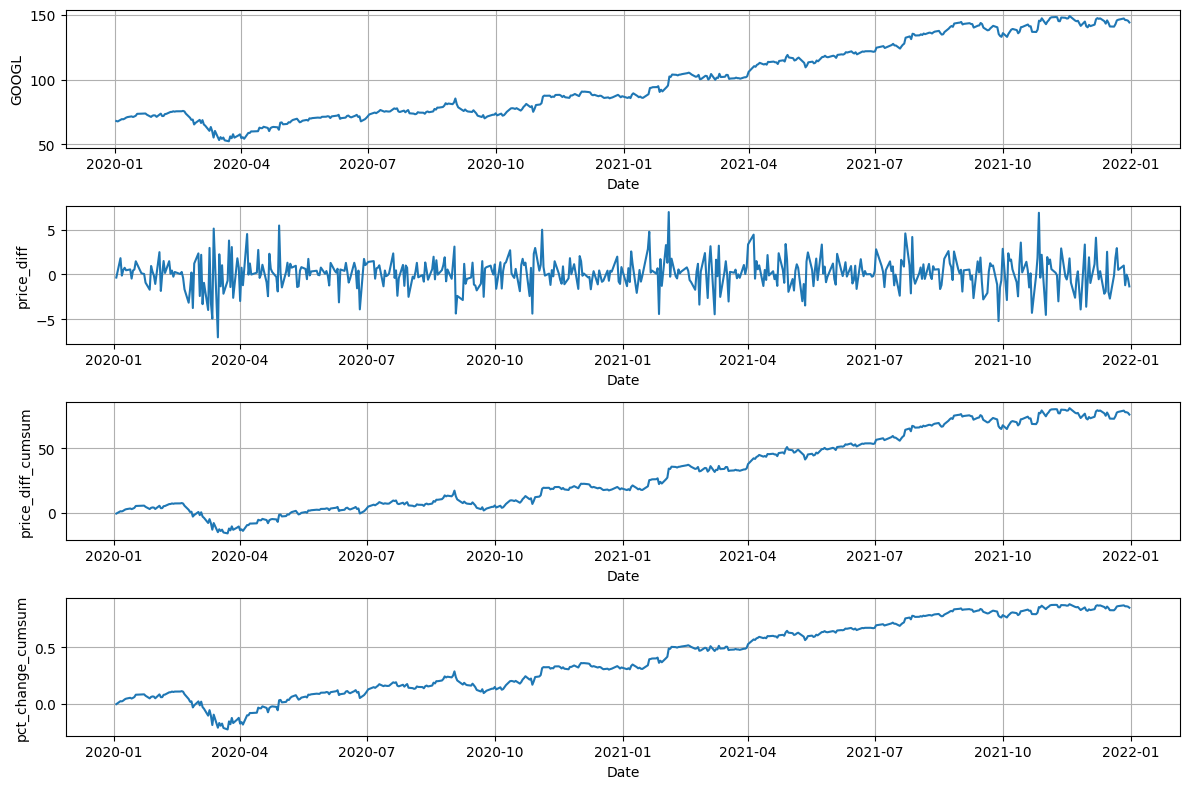

In [46]:
data["price_diff"] = data["GOOGL"].diff()
data["price_diff_cumsum"] = data["price_diff"].cumsum()
data["pct_change"] = data["GOOGL"].pct_change()
data["pct_change_cumsum"] = data["pct_change"].cumsum()

fig, sub = plt.subplots(4,1,figsize=(12,8))
subs = sub.flatten()

sns.lineplot(x = data.index, y = data["GOOGL"], ax = subs[0])
sns.lineplot(x = data.index, y = data["price_diff"], ax = subs[1])
sns.lineplot(x = data.index, y = data["price_diff_cumsum"], ax = subs[2])
sns.lineplot(x = data.index, y = data["pct_change_cumsum"], ax = subs[3])


for s in subs:
    s.grid()

fig.tight_layout()

## VaR Historical Method

In [48]:
conf_level = 0.95
VaR_hist = np.percentile(data["pct_change"].dropna(), (1 - conf_level) * 100)

print(f"Historical VaR (95% confidence level): {VaR_hist:.2%}")

Historical VaR (95% confidence level): -3.07%


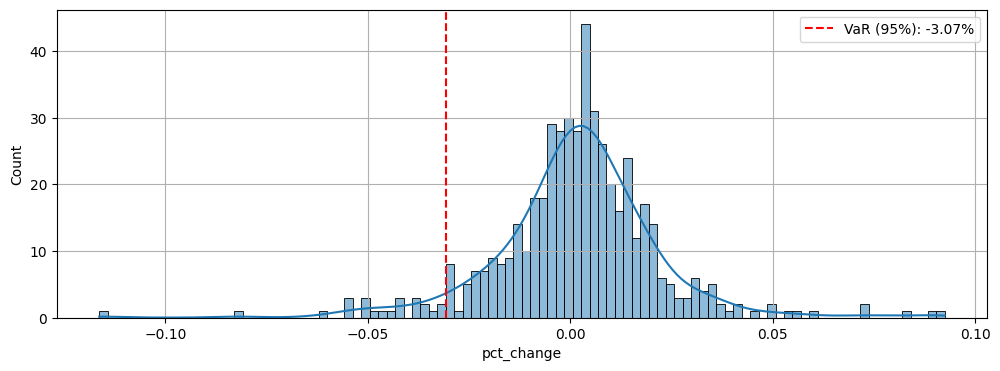

In [53]:
fig, sub = plt.subplots(1,1,figsize=(12,4))

sns.histplot(data["pct_change"], bins = 100, kde = True, ax = sub)
sub.axvline(VaR_hist, color = "red", ls = "--", label = f"VaR (95%): {VaR_hist:.2%}")
sub.legend()
sub.grid();

There is a 5 % probability that the daily returns fall below -3.07 %. 

## Variance-Covariance Method

In [58]:
mean_return = data["pct_change"].mean()
std_dev = data["pct_change"].std()

#inverse of the cdf
VaR_vc_z = norm.ppf(1 - conf_level)

print(f"Z-Score of the 5% quantile: {VaR_vc_z:.2f}")

Z-Score of the 5% quantile: -1.64


As $Z = \frac{x - \mu}{\sigma}$:

In [65]:
VaR_vc_value = mean_return + VaR_vc_z * std_dev
print(f"The Value at risk value is for an alpha=5%: {VaR_vc_value:.4f}")

The Value at risk value is for an alpha=5%: -0.0316


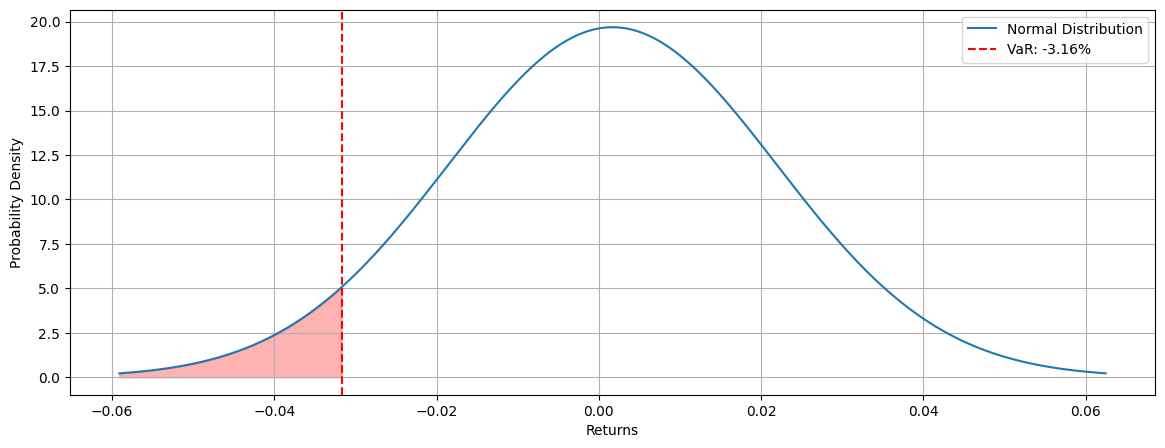

In [ ]:
fig, sub = plt.subplots(1,1,figsize=(14,5))

x_ = np.linspace(mean_return - 3*std_dev, mean_return + 3*std_dev, 1000)
y_ = norm.pdf(x_, loc = mean_return, scale = std_dev)

sns.lineplot(x = x_, y = y_, ax =sub, label = "Normal Distribution")
sub.axvline(VaR_vc_value, color = "red", ls = "--", label = f"VaR: {VaR_vc_value:.2%}")
sub.fill_between(x_, 0, y_, where = (x_ <= VaR_vc_value), color ="red", alpha = 0.3)

sub.set_xlabel("Returns")
sub.set_ylabel("Probability Density")
sub.legend()
sub.grid()

Rolling VaR

In [92]:
Period_Interval = 20
data_pct_change = data["pct_change"]

Value_at_Risk = pd.Series(index=data_pct_change.index, name = 'ParVaR')

for i in range(0,len(data_pct_change)-Period_Interval):

    if i == 0: 
        Data = data_pct_change[-(Period_Interval):]
    else: 
        Data = data_pct_change[-(Period_Interval+i):-i]


    stdev = np.std(Data, ddof=1)
    mean = np.mean(Data)
    Value_at_Risk[-i-1] = mean + stdev*norm.ppf(conf_level)

In [103]:
#or simply 
z = norm.ppf(conf_level)
Period_Interval = 20

rolling_std = data_pct_change.rolling(window = Period_Interval).std(ddof=1)
Value_at_Risk = rolling_std * z
Value_at_Risk.name = "Rolling_VaR"

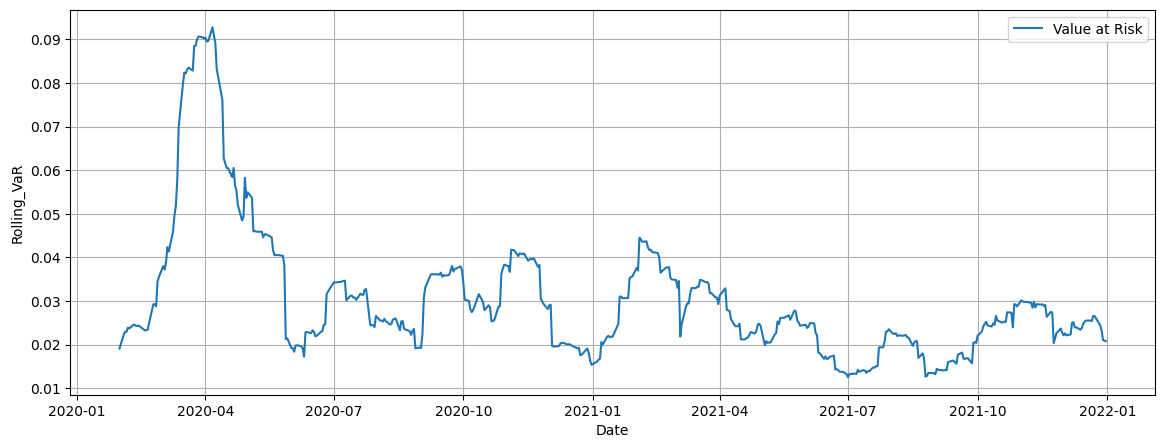

In [104]:
fig, sub = plt.subplots(1,1,figsize=(14,5))

sns.lineplot(x = Value_at_Risk.index, y = Value_at_Risk, ax = sub, label = "Value at Risk")
sub.grid()

## Monte Carlo Simulation

In [106]:
num_sim = 10000
simulation_horizon = 252

mean_ = np.mean(data_pct_change)
std_ = np.std(data_pct_change, ddof=1)

simulated_returns = np.random.normal(mean_, std_, size = (simulation_horizon, num_sim))

In [107]:
#calculation of simulated portfolio values
init_invest = 10**6
portfolio_values = init_invest * np.exp(np.cumsum(simulated_returns, axis = 0))

In [109]:
portfolio_returns = portfolio_values[-1] / portfolio_values[0]-1


In [111]:
confidence_level = 0.95
VaR_monte_carlo = np.percentile(portfolio_returns, (1-confidence_level) * 100)
print(f"Monte Carlo VaR (95% conf_level): {VaR_monte_carlo:.2%}")

Monte Carlo VaR (95% conf_level): -9.85%


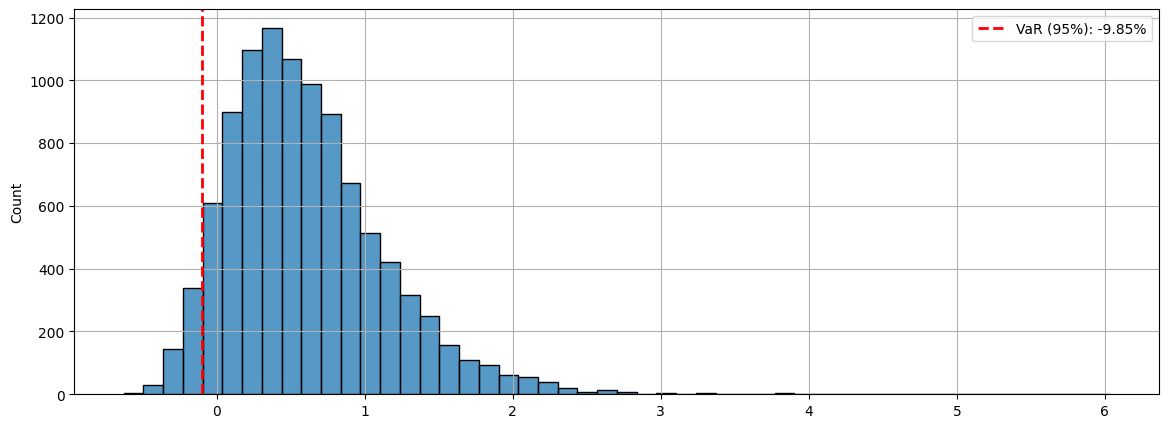

In [119]:
fig, sub = plt.subplots(1,1,figsize=(14,5))

sns.histplot(portfolio_returns, bins = 50, alpha = 0.75, edgecolor = "black", ax = sub)
sub.axvline(VaR_monte_carlo, color = "red", ls = "--", lw = 2, label=f'VaR (95%): {VaR_monte_carlo:.2%}')

sub.grid()
sub.legend();